# An introduction to copulas

## Caveat

To start off, I'd like to caveat that I'll try and do my best to explain what a copula is. I'll do my best to keep it as simple as possible so that a person with some basic concepts of probability and distribution functions can understand it. In doing so, I may be imprecise and quite likely, flat out wrong. To my astute readers, if you do catch a mistake or know a better way of describing the content, please contact me so we can discuss and improve the quality of this article.

### The audience

This is an article for beginners. If you're an undergrad who took some basic courses in math and statistics, then you're in the right place. If you need a primer on some probability and distributions, read this [quick primer](https://copulae.readthedocs.io/en/latest/examples/A-Quick-Primer-on-Probability-and-Distributions.html).

There would be *almost* no math here. So no Sklar's theorem, Fretchet-Hoffding bounds, etc, etc. Alrighty, let's start *yet another* introduction to copulas.

## A simple explanation of Copulas

From [Wikipedia](https://en.wikipedia.org/wiki/Copula_(probability_theory))'s definition:

> A copula is a multivariate cumulative distribution function for which the marginal probability distribution of each
variable is uniform on the interval [0, 1]. Copulas are used to describe the dependence between random variables.

What did those 2 sentences mean? This could be a little hard to digest at the start. No worries, we'll run through some simple examples to elucidate the concept. To do so, we'll tackle these few keywords

1. **multivariate cumulative distribution function**
2. **marginal probability distribution** (for which each variable is uniform between the interval [0, 1])

### Multivariate distributions

In school, we likely have studied multivariate distributions in the form of multivariate Gaussian distributions. This means we have at least 2 data series, each with their own mean and variance, and with their joint distribution described by a correlation matrix.

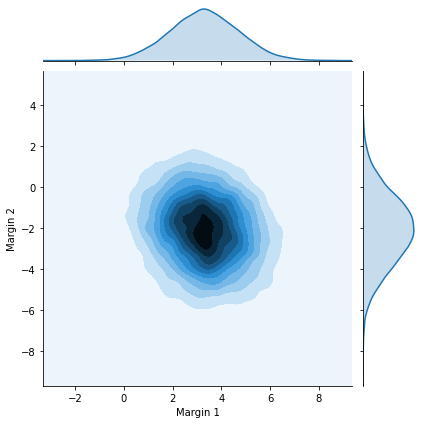

In [1]:
from scipy.stats import multivariate_normal as mvn

import pandas as pd
import seaborn as sns


# the multivariate gaussian can simply be described by the means and covariance matrix too
cov_matrix = [[2, -0.45],
              [-0.45, 3]]
means = [3.3, -2.1]

mvn_dist = mvn(mean = means, cov = cov_matrix)
mvn_rvs = pd.DataFrame(mvn_dist.rvs(10000), columns=["Margin 1", "Margin 2"])

sns.jointplot("Margin 1", "Margin 2", data=mvn_rvs, kind='kde', height=6)

Based on the following parameterizations

```python
cov_matrix = [[2, -0.45],
              [-0.45, 3]]
means = [3.3, -2.1]

# The correlation matrix is
corr_matrix = [[ 1.        , -0.18371173],
               [-0.18371173,  1.        ]]

# There is a helper function to retrieve the correlation matrix from the covariance matrix
from copulae.core import cov2corr, corr2cov
```

We see that this multivariate Gaussian has 2 marginal components. One is a $N(3, \sqrt{2})$ and the other is $N(-2.1, \sqrt{3})$. We could now take two values and plug it into the multivariate Gaussian's CDF to find out what the probability of finding that vector of numbers or less. For example,

In [2]:
def find_prob(a: float, b: float):
    print(f"Probability of seeing ({a}, {b}) or less: {round(mvn_dist.cdf([a, b]), 4)}")

find_prob(-10, -2)
find_prob(2, -2)
find_prob(10, 10)

Probability of seeing (-10, -2) or less: 0.0
Probability of seeing (2, -2) or less: 0.0744
Probability of seeing (10, 10) or less: 1.0


Let's write some definitions and what we've just seen in some pseudo math. 

$
\begin{align}
X_1 &\sim N(3, \sqrt{2}) \\
X_2 &\sim N(-2.1, \sqrt(3)) \\
F_1(x_1) &= \text{Normal Marginal 1 CDF} \\
         &= u_1 \\
F_2(x_1) &= \text{Normal Marginal 2 CDF} \\
         &= u_2 \\
F^{-1}_1(u_1) &= \text{Quantile Function 1} \\
              &= x_1 \\
F^{-1}_2(u_2) &= \text{Quantile Function 2} \\
              &= x_2 \\
P(X_1, X_2) &= \text{Probability of seeing the two numbers} \\
            &= c \left( F^{-1}_1(u_1), F^{-1}_2(u_2) \right)
\end{align}
$

where $c(\cdot)$ is a magical (pdf) function that takes in the marginal values and returns the probability of seeing the values. You might want to ask, why did we write it in such a complicated manner? Why not write is simply as $C(x_1, x_2)$? The answer to that is because this is the *secret* to what a copula is. 

In the multivariate Gaussian case, $C$ is the Guassian distribution also defined by the correlation. However, imagine if we could now

1. Switch the function $C$, such that we are no longer restricted to a Gaussian but could also use a Student-T or any other type of dependency structure
2. We could switch out the marginals, such that we could have an Student-T marginal for one and a Laplace distribution for another

As you see in the example above, using a CDF function, we can convert a variable to a number between `[0, 1]`. And using a quantile function, we can convert a variable between `[0, 1]` to any value within the distribution. The flexibility to switch the marginals and dependency structure is in effect what a copula is and what makes it so flexible in fitting data.

### Back to the definitions

> A copula is a multivariate cumulative distribution function for which the marginal probability distribution of each
variable is uniform on the interval `[0, 1]`. Copulas are used to describe the dependence between random variables.

In textbooks, a copula is usually defined like 

$$
C(u_1, u_2, \dots, u_n) = P(U_1 \leq u_1, U_2 \leq u_2, \dots, U_n \leq u_n)
$$

Where $U$ symbolizes a uniform random variable between `[0, 1]`. Based on what we've learn above, we start by rewriting parts of the formula. 

First off, some pseudo math rewriting

$
U_1 \leq u_1 \sim \text{looks like a CDF} \\
F_1(x_1) = P(X_1 \leq x_1)
$

This means, as long as we can convert something to a uniform variable, we can put it in a copula and create some joint distributions. To solidify this concept, let's start by generating some random variables using the concepts we've seen.

### Generating data - "Copula" style

Let's assume we are some super-powered divine entity. Maybe the God of Fortune if you're Taoist. Our daily job is to determine the returns of stocks for those silly human gamblers who call themselves investors. To do our job, we select a marginal distribution for each stock and also a joint distribution for all of them. The joint distribution we call the **dependency structure**. 

In this world that we are in, there are only 2 stocks, **A** and **B**. **A** follows a [Student distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with 16 df, 0.05 mean and 1.2 standard deviation. **B** follows a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with a mean of 0.1 and 1.5 standard deviation. The dependency structure is a Gaussian copula with mean `[0, 0]` and covariance `[[1, 0.2], [0.2, 1]]`.

Assuming today is day 0, let's do our job and randomly generate the returns profile for the 2 stocks for the next 10 days.

The pseudo-algorithm for the process is as follows:

In [3]:
import numpy as np
from scipy.stats import laplace, multivariate_normal as mvn, t

np.random.seed(1234)
m1 = t(df=16, loc=0.05, scale=1.2)  # marginal for stock A
m2 = laplace(loc=0.1, scale=1.5)  # marginal for stock B
ds = mvn(mean=[0, 0], cov=[[1, 0.2], [0.2, 1]])  # dependency structure

# first we generate some random variables from the dependency structure
rvs = ds.rvs(size=10)
rvs

array([[ 0.38806706, -1.11841127],
       [-0.91203162, -1.30750847],
       [-0.00292548,  1.11925674],
       [-0.26326151, -1.06840713],
       [ 1.40624015, -1.43055686],
       [-1.51817559, -0.26345209],
       [ 0.5399121 , -2.01679549],
       [ 0.25743544,  0.26011499],
       [-0.49690066, -0.13122506],
       [-0.04501576, -2.00171371]])

Now that we have this set of random variables that describes the dependency structure for the 2 distributions, what we need to do next is to convert these variables into their respective distribution's values. This sounds confusing but is actually really simple.

It's just a bunch of inverse transforms and cdfs.

In [4]:
from scipy.stats import norm

# note that its 0 and 1 because in the multivariate normal distribution, we set the mean and variance
# to 0 and 1 for both the distributions. If we had changed the mean and variance, we just need to alter
# the values accordingly. The scale is standard deviation. So if you used a covariance matrix like 
# [[9, 4], [4, 16]], then the scale would be 3 and 4 respectively
x1 = norm(loc=0, scale=1).cdf(rvs[:, 0])
x2 = norm(loc=0, scale=1).cdf(rvs[:, 1])

# remember that CDF converts a value to a number between [0, 1]. Which means the probability of seeing that
# value or less
pd.DataFrame({"x1": x1, "x2": x2}).round(4)

,x1,x2
0,0.6510,0.1317
1,0.1809,0.0955
2,0.4988,0.8685
3,0.3962,0.1427
4,0.9202,0.0763
5,0.0645,0.3961
6,0.7054,0.0219
7,0.6016,0.6026
8,0.3096,0.4478
9,0.4820,0.0227


After getting this variables between `[0, 1]`, you can then apply the inverse transform to get the distribution's values.

In [5]:
t_rvs = t(df=16, loc=0.05, scale=1.2).ppf(x1)
laplace_rvs = laplace(loc=0.1, scale=1.5).ppf(x2)

# Returns of Stock A and B in percentage
pd.DataFrame({"A": t_rvs, "B": laplace_rvs}).round(4)

,A,B
0,0.5242,-1.9012
1,-1.0767,-2.3829
2,0.0464,2.1032
3,-0.2712,-1.7811
4,1.8198,-2.7203
5,-1.8710,-0.2494
6,0.7112,-4.5950
7,0.3641,0.4445
8,-0.5581,-0.0654
9,-0.0049,-4.5412


That's it, that's how you generate random variables. 

Now let's explore how different this is from a multivariate distribution. However, let's switch to more extreme distributions to highlight the differences.

In [6]:
from scipy.stats import pareto, weibull_min


def plot_extreme_jointplots(rvs):
    x1 = norm(loc=0, scale=1).cdf(rvs[:, 0])
    x2 = norm(loc=0, scale=1).cdf(rvs[:, 1])
    df1 = pd.DataFrame({
        "A": weibull_min(c=0.8, loc=0.05, scale=1.2).ppf(x1),
        "B": pareto(b=4, loc=0.1, scale=1.5).ppf(x2)
    })

    sns.jointplot("A", "B", data=df1, kind='kde', height=8,
                  xlim=(df1.A.min(), 3), ylim=(df1.B.min(), 3))


def plot_multivariate_normal_jointplots(rvs):
    df1 = pd.DataFrame({
        "A": rvs[:, 0],
        "B": rvs[:, 1]
    })

    sns.jointplot("A", "B", data=df1, kind='kde', height=8)

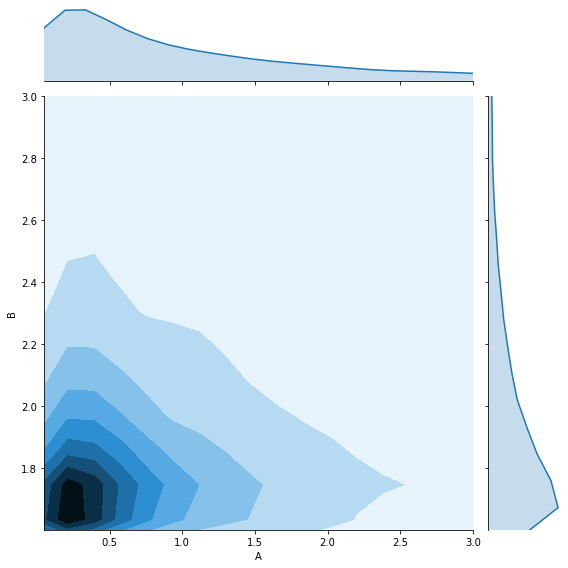

In [7]:
np.random.seed(888)
rvs = ds.rvs(size=10000)

plot_extreme_jointplots(rvs)

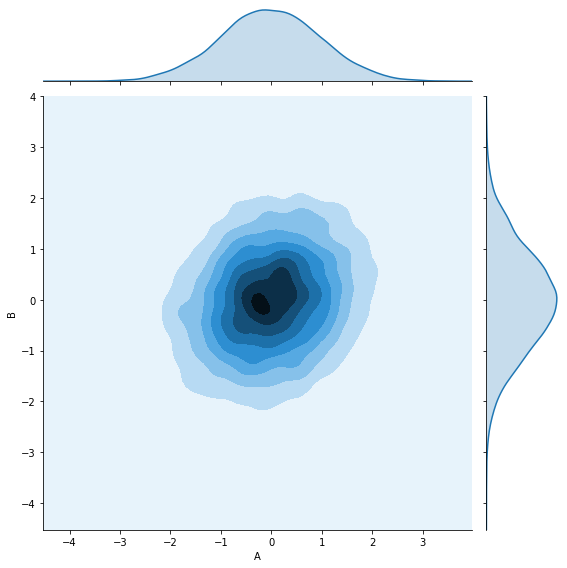

In [8]:
plot_multivariate_normal_jointplots(rvs)

Observe from the two plots above, how we started from a similar dependency structure but somehow got very different
joint distributions. This is essentially a copula.

## The End

That's it for this short introduction. Hope it shed some light on how a copula works. It's a pretty high level overview and ignores a lot of math. I hope to be able to write a more precise document on it in the near future (barring any work commitments 😩).

But more than that, I also hope to write some example use-cases. I find that running through (pseudo) real-world practical examples is usually a better pedagogical tool after all. Till then.
